# Simulations reported in Section 3

### Enable parallel computing, and load required packages

In [1]:
using Distributed
addprocs()
@everywhere using Distributions, StatsBase, LinearAlgebra, SharedArrays, Random
using DataFrames, Gadfly, Colors, HypothesisTests, RCall

### Graphics defaults

In [2]:
function gen_brew_colors(n)
    cs = distinguishable_colors(n,
        [colorant"#66c2a5", colorant"#fc8d62", colorant"#8da0cb", colorant"#e78ac3",
            colorant"#a6d854", colorant"#ffd92f", colorant"#e5c494", colorant"#b3b3b3"],
        lchoices=Float64[58, 45, 72.5, 90],
        transform=c->deuteranopic(c, 0.1),
        cchoices=Float64[20,40],
        hchoices=[75,51,35,120,180,210,270,310]
    )
    convert(Vector{Color}, cs)
end

set_default_plot_size(9inch, 9inch/MathConstants.golden)

### Set parameters, define priors and likelihoods, and generate data

In [3]:
@everywhere begin 
    const numb_hyp = 11
    const numb_toss = 500
    const numb_sim = 1000
    const prior = fill(1/numb_hyp, numb_hyp)
    const likelihood_heads = range(0, stop=1, length=numb_hyp)
    const likelihood_tails = range(1, stop=0, length=numb_hyp)
end

datFunc(bias) = rand(Bernoulli(bias), numb_toss)

@everywhere sim_dat = Array{Bool,3}(undef, numb_sim, numb_toss, numb_hyp);

for i in 1:numb_hyp, j in 1:numb_sim
    sim_dat[j, :, i] = datFunc((i - 1) / (numb_hyp - 1))
end

### Update rules

In [4]:
@everywhere function b_upd(probs::Array{Float32,1}, dat::Array{Bool,1}, toss_num::Int)
    if dat[toss_num] == 1
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end
end

In [5]:
@everywhere function expl_upd(probs::Array{Float32,1}, dat::Array{Bool,1}, toss_num::Int, bonus::Float64=0.01)
    val::Float32 = mean(dat[1:toss_num]) * 10 + 1
    vec::Array{Float32,1} = if dat[toss_num] == 1
            @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
        else
            @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
        end

    if val % 1 == .5
        vec[floor(Int, val)] += .5*bonus
        vec[ceil(Int, val)] += .5*bonus
    else
        vec[round(Int, val, RoundNearestTiesAway)] += bonus
    end

    return vec / sum(vec)
end

### Running the simulations

In [6]:
# for Bayes' rule
bayesRes = SharedArray{Float32,4}(numb_toss + 1, numb_hyp, numb_sim, numb_hyp)

@inbounds for h in 1:numb_hyp, s in 1:numb_sim
    bayesRes[1, :, s, h] = prior
end

@sync @distributed for h in 1:numb_hyp
    @fastmath @inbounds for s in 1:numb_sim, t in 1:numb_toss
        bayesRes[t + 1, :, s, h] = b_upd(bayesRes[t, :, s, h], sim_dat[s, :, h], t)
    end
end;

In [7]:
# for EXPL
explRes = SharedArray{Float32,4}(numb_toss + 1, numb_hyp, numb_sim, numb_hyp)

@inbounds for h in 1:numb_hyp, s in 1:numb_sim
    explRes[1, :, s, h] = prior
end

@sync @distributed for h in 1:numb_hyp
    @fastmath @inbounds for s in 1:numb_sim, t in 1:numb_toss
       explRes[t + 1, :, s, h] = expl_upd(explRes[t, :, s, h], sim_dat[s, :, h], t)
    end
end;

### Convergence

In [8]:
@everywhere function ff(res::SharedArray{Float32,4}, sim::Int64, bias::Int64, thresh::Float64=.9)
    ff = findfirst(res[:, bias, sim, bias] .> thresh)
    out = ff == nothing ? numb_toss : ff
end

In [9]:
convResBayes = SharedArray{Int32,2}(numb_sim, div((numb_hyp - 1), 2))

@sync @distributed for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        convResBayes[j, i] = ff(bayesRes, j, i + 1)
    end
end;

In [10]:
convB = DataFrame(convert(Array, convResBayes))
names!(convB, [Symbol("$i") for i in .1:.1:.5]);

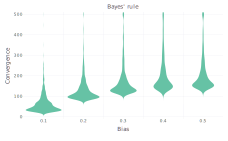

In [11]:
plot(convB,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Convergence"),
    Guide.title("Bayes' rule"),
    Scale.x_discrete(levels=names(convB)),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

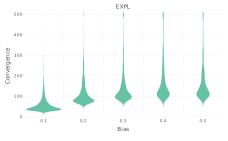

In [12]:
convResEXPL = SharedArray{Int32,2}(numb_sim, div((numb_hyp - 1), 2))

@sync @distributed for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        @inbounds convResEXPL[j, i] = ff(explRes, j, i + 1)
    end
end

convE = DataFrame(convert(Array, convResEXPL))
names!(convE, [Symbol("$i") for i in .1:.1:.5])

plot(convE,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Convergence"),
    Guide.title("EXPL"),
    Scale.x_discrete(levels=names(convE)),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

### Stable convergence

In [13]:
@everywhere function ffs(res::SharedArray{Float32,4}, sim::Int64, bias::Int64, thresh::Float64=.9)
    ff = findfirst(res[:, bias, sim, bias][end:-1:1] .< thresh)
    out = ff == nothing ? numb_toss : ff
    return (numb_toss - out) + 1 
end

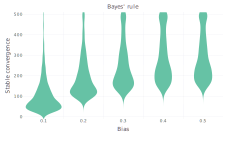

In [14]:
convResBayesS = SharedArray{Int32,2}(numb_sim, div((numb_hyp - 1), 2));

@sync @distributed for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        convResBayesS[j, i] = ffs(bayesRes, j, i + 1)
    end
end

convBS = DataFrame(convert(Array, convResBayesS))
names!(convBS, [Symbol("$i") for i in .1:.1:.5])

plot(convBS,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Stable convergence"),
    Guide.title("Bayes' rule"),
    Scale.x_discrete(levels=names(convBS)),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

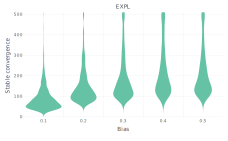

In [15]:
convResEXPLS = SharedArray{Int32,2}(numb_sim, div((numb_hyp - 1), 2));

@sync @distributed for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        convResEXPLS[j, i] = ffs(explRes, j, i + 1)
    end
end

convES = DataFrame(convert(Array, convResEXPLS))
names!(convES, [Symbol("$i") for i in .1:.1:.5])

plot(convES,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Stable convergence"),
    Guide.title("EXPL"),
    Scale.x_discrete(levels=names(convES)),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

### Statistics

In [16]:
[ pvalue(MannWhitneyUTest(convB[:, i], convE[:, i])) for i in 1:5 ]

5-element Array{Float64,1}:
 0.401173860880448     
 3.6317884737331777e-38
 1.0196939728146502e-56
 6.019199172276073e-51 
 8.545902512396258e-64 

In [17]:
[ pvalue(MannWhitneyUTest(convBS[:, i], convES[:, i])) for i in 1:5 ]

5-element Array{Float64,1}:
 0.1290887073888899    
 1.3308983341135181e-37
 1.688344956151406e-52 
 7.362046386311786e-47 
 5.812838944922494e-64 

### Scoring

In [18]:
function brierScore(mat, r, sim, hyp)
    (1 - mat[r, :, sim, hyp][hyp])^2 + sum((deleteat!(mat[r, :, sim, hyp], hyp)).^2)
end

function brierVals(mat, sim, hyp)
    vals = Float64[]
    for i in 1:numb_toss
        push!(vals, brierScore(mat, i + 1, sim, hyp))
    end
    return vals
end

brierVals (generic function with 1 method)

In [19]:
brierBayesRes = Array{Float64,3}(undef, numb_toss, numb_sim, numb_hyp)

for i in 1:numb_hyp
    for j in 1:numb_sim
        brierBayesRes[:, j, i] = brierVals(bayesRes, j, i)
    end
end

brierBayesMeans = Array{Float64,2}(undef, numb_toss, numb_hyp)

for i in 1:numb_hyp
    brierBayesMeans[:, i] = mean(brierBayesRes[:, :, i], dims=2)
end

brierEXPLRes = Array{Float64,3}(undef, numb_toss, numb_sim, numb_hyp)

for i in 1:numb_hyp
    for j in 1:numb_sim
        brierEXPLRes[:, j, i] = brierVals(explRes, j, i)
    end
end

brierEXPLMeans = Array{Float64,2}(undef, numb_toss, numb_hyp)

for i in 1:numb_hyp
    brierEXPLMeans[:, i] = mean(brierEXPLRes[:, :, i], dims=2)
end

In [20]:
bayesConf = Array{Float64,2}(undef, 11, 3)

for i in 1:11
    bayesConf[i, :] = vcat(mean(brierBayesMeans[:, i]), [confint(OneSampleTTest(brierBayesMeans[:, i]))...])
end

explConf = Array{Float64,2}(undef, 11, 3)

for i in 1:11
    explConf[i, :] = vcat(mean(brierEXPLMeans[:, i]), [confint(OneSampleTTest(brierEXPLMeans[:, i]))...])
end

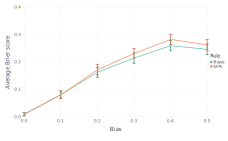

In [21]:
conf_df = convert(DataFrame, vcat(bayesConf, explConf))
names!(conf_df, [Symbol("$i") for i in ["y", "ymin", "ymax"]])
conf_df[:Bias] = repeat(collect(0.0:0.1:1.0), outer=2)
conf_df[:Rule] = repeat(["Bayes", "EXPL"], inner=11)
conf5_df = conf_df[conf_df[:Bias].<0.6, :]

ticks = collect(0.0:0.1:0.5)
plot(conf5_df, x=:Bias, y=:y, ymin=:ymin, ymax=:ymax, color=:Rule, Geom.line, Geom.errorbar,
    Guide.ylabel("Average Brier score"),
    Guide.xticks(ticks=ticks),
    Scale.color_discrete_manual(gen_brew_colors(2)...),
    style(line_width=2pt, minor_label_font_size=12pt, major_label_font_size=16pt,
            key_label_font_size=11pt, key_title_font_size=14pt,
            colorkey_swatch_shape=:square))

### Statistics

Is Bayes' rule *significantly* more accurate than EXPL?

In [22]:
[ pvalue(EqualVarianceTTest(brierBayesMeans[:, i], brierEXPLMeans[:, i])) for i in 1:6 ]

6-element Array{Float64,1}:
 0.682708996102327  
 0.9415226985351863 
 0.4920215897359336 
 0.22227050932809372
 0.08776296409961815
 0.23563376739083836

Speed-accuracy trade-off

In [23]:
convBayesSAT = SharedArray{Int32,2}(numb_sim, 11)

@sync @distributed for i in 1:11
    for j in 1:numb_sim
        convBayesSAT[j, i] = ff(bayesRes, j, i)
    end
end

convEXPLSAT = SharedArray{Int32,2}(numb_sim, 11)

@sync @distributed for i in 1:11
    for j in 1:numb_sim
        convEXPLSAT[j, i] = ff(explRes, j, i)
    end
end

convBayesSATS = SharedArray{Int32,2}(numb_sim, 11)

@sync @distributed for i in 1:11
    for j in 1:numb_sim
        convBayesSATS[j, i] = ffs(bayesRes, j, i)
    end
end

convEXPLSATS = SharedArray{Int32,2}(numb_sim, 11)

@sync @distributed for i in 1:11
    for j in 1:numb_sim
        convEXPLSATS[j, i] = ffs(explRes, j, i)
    end
end

Task (done) @0x000000011cadb850

In [24]:
x1 = mapslices(mean, convBayesSAT, dims=1)
x2 = mapslices(mean, convEXPLSAT, dims=1)
x3 = mapslices(mean, convBayesSATS, dims=1)
x4 = mapslices(mean, convEXPLSATS, dims=1)

y1 = mapslices(mean, brierBayesMeans, dims=1)
y2 = mapslices(mean, brierEXPLMeans, dims=1);

In [25]:
@rput x1
@rput x2
@rput x3
@rput x4
@rput y1
@rput y2;

In [26]:
R"cor.test(x1, y1)"

RObject{VecSxp}

	Pearson's product-moment correlation

data:  x1 and y1
t = 34.136, df = 9, p-value = 7.839e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9847360 0.9990384
sample estimates:
      cor 
0.9961605 



In [27]:
R"cor.test(x3, y1)"

RObject{VecSxp}

	Pearson's product-moment correlation

data:  x3 and y1
t = 53.81, df = 9, p-value = 1.329e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9938147 0.9996120
sample estimates:
      cor 
0.9984495 



In [28]:
R"cor.test(x2, y2)"

RObject{VecSxp}

	Pearson's product-moment correlation

data:  x2 and y2
t = 64.025, df = 9, p-value = 2.792e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9956250 0.9997258
sample estimates:
     cor 
0.998904 



In [29]:
R"cor.test(x4, y2)"

RObject{VecSxp}

	Pearson's product-moment correlation

data:  x4 and y2
t = 33.747, df = 9, p-value = 8.684e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9843863 0.9990162
sample estimates:
      cor 
0.9960721 

